In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.applications import resnet50, vgg16, xception, inception_resnet_v2, mobilenet_v2, densenet
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import accuracy_score

In [ ]:
folder_benign_train = '/content/drive/MyDrive/MachineLearning_dataset/data/train/benign'
folder_malignant_train = '/content/drive/MyDrive/MachineLearning_dataset/data/train/malignant'

folder_benign_test = '/content/drive/MyDrive/MachineLearning_dataset/data/test/benign'
folder_malignant_test = '/content/drive/MyDrive/MachineLearning_dataset/data/test/malignant'

In [ ]:
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

In [ ]:
# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

In [ ]:
# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

In [ ]:
# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

In [ ]:
# Shuffle data
s = np.arange(X_train.shape[0]) #array sorted from 0 to X_train.shape[0] -1
np.random.shuffle(s) #shuffling the content of s
X_train = X_train[s] #shuffling images and labels the same way
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

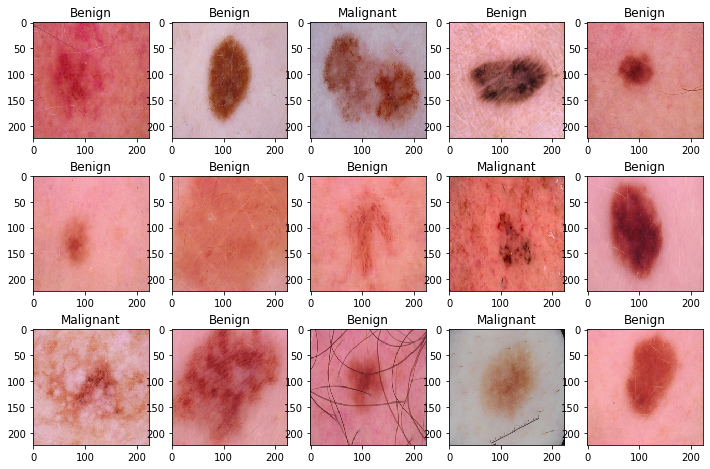

In [ ]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

del folder_benign_train,folder_malignant_train,folder_benign_test,folder_malignant_test,read,ims_benign,ims_malignant,X_benign,X_malignant,X_benign_test,X_malignant_test,y_benign,y_malignant,y_benign_test,y_malignant_test,s,ax,columns,rows

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

In [ ]:
model_Vgg16 = Sequential(
    [
        Input(shape=(224,224,3)),
        preprocessing.RandomRotation(factor=0.5),
        preprocessing.RandomFlip()
    ],
    name = "VGG16"
)
for layer in vgg16.VGG16().layers[:-1]:
    model_Vgg16.add(layer)
model_Vgg16.add(Dropout(0.7))
model_Vgg16.add(Dense(1, activation='sigmoid'))
model_Vgg16.summary()

model_Vgg16.compile(optimizer = Adam(5e-5) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

Model: "VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_2 (ModuleWrap (None, 224, 224, 3)       0         
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 224, 224, 3)       0         
_________________________________________________________________
input_4 (InputLayer)         multiple                  0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856 

In [ ]:
history = model_Vgg16.fit(vgg16.preprocess_input(X_train), y_train, validation_split=0.1,
                    epochs= 20, batch_size= 64, verbose=2, 
                    callbacks=[learning_rate_reduction,ModelCheckpoint("VGG16.h5", monitor='val_accuracy',save_weights_only=True, mode='max', save_best_only=True, verbose=2)])

Epoch 1/20
38/38 - 66s - loss: 0.5137 - accuracy: 0.7602 - val_loss: 0.3850 - val_accuracy: 0.8144

Epoch 00001: val_accuracy improved from -inf to 0.81439, saving model to VGG16.h5
Epoch 2/20
38/38 - 62s - loss: 0.3915 - accuracy: 0.8167 - val_loss: 0.4124 - val_accuracy: 0.8258

Epoch 00002: val_accuracy improved from 0.81439 to 0.82576, saving model to VGG16.h5
Epoch 3/20
38/38 - 62s - loss: 0.3370 - accuracy: 0.8424 - val_loss: 0.3599 - val_accuracy: 0.8182

Epoch 00003: val_accuracy did not improve from 0.82576
Epoch 4/20
38/38 - 62s - loss: 0.2744 - accuracy: 0.8689 - val_loss: 0.3939 - val_accuracy: 0.8371

Epoch 00004: val_accuracy improved from 0.82576 to 0.83712, saving model to VGG16.h5
Epoch 5/20
38/38 - 62s - loss: 0.2897 - accuracy: 0.8647 - val_loss: 0.3288 - val_accuracy: 0.8371

Epoch 00005: val_accuracy did not improve from 0.83712
Epoch 6/20
38/38 - 62s - loss: 0.2577 - accuracy: 0.8883 - val_loss: 0.3865 - val_accuracy: 0.8371

Epoch 00006: val_accuracy did not impr

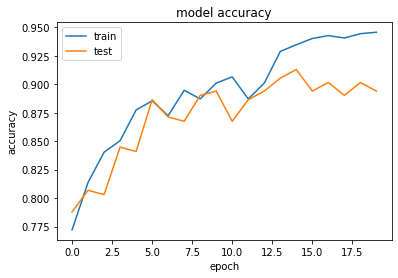

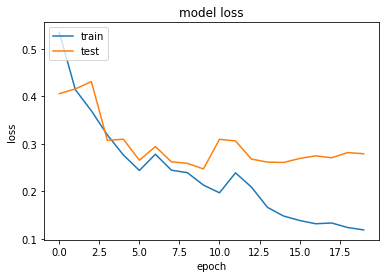

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()